# Getting Started with ``spore``

``spore`` is a set of modules/classes/functions to self-consistently create low-frequency radio interferometric EoR foreground models and analyse them in different ways.
It centres around 3 basic tasks, each implemented as its own sub-package, which can interact to some degree: 
1. ``model``: define individual foreground model components analytically, and combine them analytically.
2. ``mock``: combine different ``model``s to produce a sampled realisation of the sky.
3. ``measure``: given a realisation of the sky (either a result from a ``mock`` or from some external simulation), make measurements of the power spectrum on it.

``spore`` also contains a sub-package dedicated to visualising these results.

In this notebook we'll show some simple examples of how to use the above three sub-packages, focusing on creating ``model``s. First, we'll do a few imports to set us up.

In [1]:
import numpy as np
from spore.mock.ps_foregrounds import PointSourceForegrounds, PointSourceForegroundsDirect

import matplotlib.pyplot as plt
%matplotlib inline

## Model

At this time, ``spore`` defines 4 kinds of models (we'll call them component models): beam models, source counts, spatial distributions, and spectral index distributions. They are imported as follows:

In [2]:
from spore.model import beam, source_counts, spatial_dist, spectral_index

Each module comprises a base component class, along with some number of specific models for that component. The idea behind this layout is that you can define your own specific models for that component in your own code, by subclassing the base component class and following its API. Let's have a brief look at each component.

### Beam Models

The base component class for beam models is ``Beam``. It's input API is such that 1 necessary parameter is present: ``nu0`` which defines the reference frequency for the beam parameters.

The main output API that the subclass must implement is ``beam``, which takes a vector of ``l`` (and optionally ``m``) and evaluates beam attenuation at those co-ordinates, at frequency ``f0`` which defines the frequency (as a ratio to ``nu0``) at which the beam quantities are to be evaluated. This latter can be an array. If so, the returned array has an extra dimension (which can get quite large very quickly).

The obvious simple model is a Circular Gaussian beam, and this is implemented within the class. To call it, use

In [3]:
gaussbeam = beam.CircularGaussian(nu0=150., D=4.) #Note D is the diameter of the array tile.

One can evaluate attenuation at any co-ordinate:

In [4]:
gaussbeam.beam(np.array([0]))

<Quantity [[ 1.]]>

In [5]:
gaussbeam.beam(np.array([0]), np.array([0.2]))

<Quantity [[ 0.634992]]>

In [6]:
gaussbeam.beam(np.linspace(0,1,10), f0=np.array([1,1.5]))

<Quantity [[  1.00000000e+00,  8.69212582e-01,  5.70826355e-01,
              2.83226599e-01,  1.06173483e-01,  3.00711545e-02,
              6.43481620e-03,  1.04033737e-03,  1.27076212e-04,
              1.17275240e-05],
           [  1.00000000e+00,  7.29513796e-01,  2.83226599e-01,
              5.85196315e-02,  6.43481620e-03,  3.76563073e-04,
              1.17275240e-05,  1.94375691e-07,  1.71452802e-09,
              8.04848693e-12]]>

### Source Counts Models

The base component class for source counts is ``SourceCounts``. To it, one must pass ``Smin0`` (the faintest sources at ``nu0``), ``Smax0`` (the brightest sources at ``nu0``), ``f0`` and ``spectral_index``. Along with these, each subclass will define its own set of additional parameters. The simplest example is a power-law:

In [7]:
pl_source_counts = source_counts.PowerLawSourceCounts(Smin0=1e-2, Smax0=1.0, f0=1.0, # Default for spectral_index is 0.8
                                                      alpha=6998.,  # Normalisation of powr=er-law
                                                      beta =1.54   # Slope of power-law
                                                     )

One can evaluate a few simple quantities:

In [8]:
print(pl_source_counts.total_number_density)
print(pl_source_counts.total_flux_density)
print(pl_source_counts.total_squared_flux_density)

142845.305805 1 / sr
13384.0333666 Jy / sr
4787.38805033 Jy2 / sr


One can evaluate the actual source counts at any flux density (at $\nu_0$):

In [9]:
pl_source_counts.dnds(0.5)

<Quantity 20349.799352415066 1 / (Jy sr)>

In addition, one can evaluate any moment of the source counts (defined as $\mu_n = \int S^n \frac{dN}{dS} dS$):

In [10]:
pl_source_counts.mu(1)

<Quantity 13384.033366640728 Jy / sr>

Finally, one can sample the source counts (at $\nu_0$):

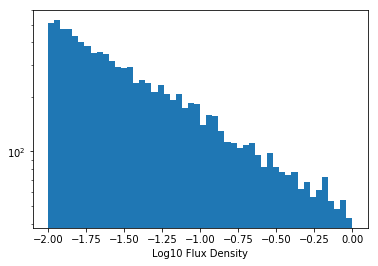

In [11]:
fluxes = pl_source_counts.sample_source_counts(10000)

plt.hist(np.log10(fluxes.value),bins=50)
plt.yscale('log')
plt.xlabel("Log10 Flux Density")

### Spectral Index

At this point, there are only a couple of spectral index distribution models. Note that these all assume that a source has a power-law SED within the bandwidth of interest. Perhaps later versions will generalise to more complicated SED's. The most common/easy spectral index distribution is the universal one (i.e. every source has the same spectral index):

In [12]:
spec_index_dist = spectral_index.UniversalDist(0.8)

This object has a method to sample this distribution:

In [13]:
spec_index_dist.sample(n=10)

array([ 0.8,  0.8,  0.8,  0.8,  0.8,  0.8,  0.8,  0.8,  0.8,  0.8])

### Spatial Distributions

There are two fundamentally different kinds of spatial distribution -- those that have shot noise from the discreteness of sources, and those that do not. All of these are contained in the ``spatial_dist`` module, and are subclassed from the ``SpatialDistribution`` base component class.

We'll use an example of both here:

In [14]:
pure_sky = spatial_dist.PureClustering_FlatSky(f0 = 1., # Frequencies (as ratios to ref. freq.) to evaluate sky at.
                                               sky_size = 2.0,             # Size of sky in l,m co-ordinates
                                               ncells = 256,              # Number of grid cells along a side 
                                               seed = 1234,                # Optional seed to enforce the same realisation on every run
                                               power_spectrum = lambda u : (u/0.1)**-2.0   # A function defining an isotropic power spectrum of sources as a function of scale u.
                                              )

# Define poisson sky with all the same parameters
poisson_sky = spatial_dist.PoissonClustering_FlatSky(
                                               f0 = 1.,
                                               sky_size = 2.0,             
                                               ncells = 256,              
                                               seed = 1234,                
                                               power_spectrum = lambda u : (u/0.1)**-2.0
                                              )


To create a uniformly distributed sky, one just needs to not pass the ``power_spectrum`` argument

The most relevant method of these classes is ``sky``. It gives a grid of sky brightnesses, at all frequencies. One thing to keep in mind is the "pure" clustering classes have a different signature for this method. They require only a mean brightness (for all frequencies), whereas "poisson" classes require an array of source positions, fluxes and spectral indices. We'll show both here:

/home/steven/anaconda2/envs/spore/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in power
/home/steven/anaconda2/envs/spore/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in power


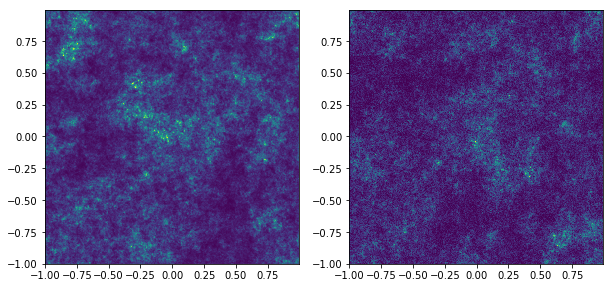

In [15]:
fig, ax = plt.subplots(1,2, figsize=(10,7))

# The pure clustering sky call.
puresky = pure_sky.sky(sbar=[10.])

# For poisson clustering, need a sample of positions. Poisson classes have a method to do this:
source_pos = poisson_sky.source_positions(nbar=100000.)
npos = len(source_pos[0])
fluxes = np.random.uniform(size=npos)
specs = 0.8 * np.ones(npos)

poissonsky = poisson_sky.sky(source_pos, fluxes, specs)

# Plot it up
ax[0].imshow(puresky[0,:,:].T, extent=(pure_sky.lgrid[0].min().value,pure_sky.lgrid[0].max().value,pure_sky.lgrid[0].min().value,pure_sky.lgrid[0].max().value), origin='lower')
ax[1].imshow(poissonsky[0,:,:].T, extent=(pure_sky.lgrid[0].min().value,pure_sky.lgrid[0].max().value,pure_sky.lgrid[0].min().value,pure_sky.lgrid[0].max().value), origin='lower')

Of course, we can also plot say a scatter-plot of the source positions themselves:

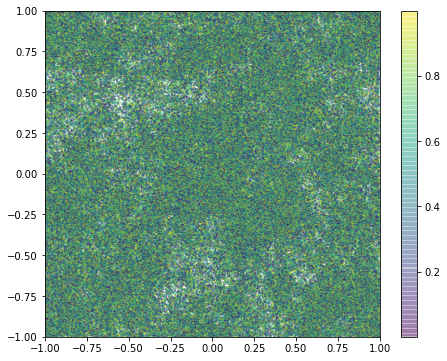

In [16]:
plt.figure(figsize=(7.5,6))
plt.scatter(source_pos[0], source_pos[1], s=1, c=fluxes, alpha = 0.3)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.colorbar()

From v0.0.3, there are also built-in classes for populating the sky treating solid-angles as equal, rather than $l,m$-coordinates. We'll show an example of this in the next section, but show here how to create them:

In [17]:
poisson_sky_sph = spatial_dist.PoissonClustering_Spherical(
                                               f0 = 1.,
                                               sky_size = 2.0,             
                                               ncells = 256,              
                                               seed = 1234,                
                                               power_spectrum = lambda l : (l/0.3)**-2.0,
                                               nside = 64,  # Resolution of underlying spherical HEALpix grid
                                               lmax = 1000  # Resolution of power spectrum itself
                                              )

pure_sky_sph = spatial_dist.PureClustering_Spherical(
                                               f0 = 1.,
                                               sky_size = 2.0,             
                                               ncells = 256,              
                                               seed = 1234,                
                                               power_spectrum = lambda l : (l/0.3)**-2.0,
                                               nside = 64,  # Resolution of underlying spherical HEALpix grid
                                               lmax = 1000  # Resolution of power spectrum itself
                                              )


## Mock

In this section, we put the models of the first section together to create a self-consistent mock. The way to do this should seem reasonably obvious by inspecting the spatial distribution setup, however, we wrap all of this in a single class. At this point, the class only deals with point-source foregrounds. To use it:

In [18]:
psf_pure = PointSourceForegrounds(beam_model=gaussbeam,
                                  source_counts=pl_source_counts,
                                  spec_index_model = spec_index_dist,
                                  spatial_dist = pure_sky)

psf_poiss = PointSourceForegrounds(beam_model=gaussbeam,
                                  source_counts=pl_source_counts,
                                  spec_index_model = spec_index_dist,
                                  spatial_dist = poisson_sky)

psf_pure_sph = PointSourceForegrounds(beam_model=gaussbeam,
                                  source_counts=pl_source_counts,
                                  spec_index_model = spec_index_dist,
                                  spatial_dist = pure_sky_sph)

psf_poiss_sph = PointSourceForegrounds(beam_model=gaussbeam,
                                  source_counts=pl_source_counts,
                                  spec_index_model = spec_index_dist,
                                  spatial_dist = poisson_sky_sph)


We pass each of the models we have created in the previous section. All of the models get saved into the class under the names they are passed as (so you can access ``psd_pure.beam_model`` for instance). Some more methods are also available, which tie together the various components. From this, we can plot the sky distribution and other quantities. Note that all of these models inherently provide the visibility gridded into the $(u,v)$ plane on a regular grid, which is defined in turn by the extent of the sky. 

Alternatively, one may use a ``Direct`` foreground model, which is able to directly calculate the visibility over an irregular $(u,v)$ layout:

In [35]:
u0 = psf_poiss.ugrid_raw0 # This is the u values on a side of the regular grid.
N_u = len(u0)
u0,v0 = np.meshgrid(u0,u0) #Construct a 2D square of values 

psf_poiss_direct = PointSourceForegroundsDirect(u0 = u0.flatten(), v0=v0.flatten(),
                                                beam_model=gaussbeam,
                                                source_counts = pl_source_counts,
                                                spec_index_model = spec_index_dist,
                                                spatial_dist = poisson_sky)

### Sky Distribution

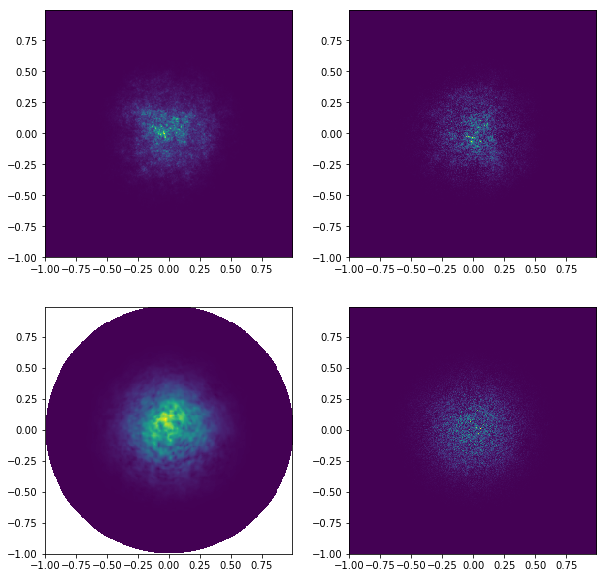

In [32]:
fig, ax = plt.subplots(2,2, figsize=(10,10))

lmin = psf_pure.spatial_dist.lgrid[0].min().value
lmax = psf_pure.spatial_dist.lgrid[0].max().value

ax[0,0].imshow(psf_pure.visible_sky()[0,:,:].T, 
             extent=(lmin,lmax,lmin,lmax), 
             origin='lower')

ax[0,1].imshow(psf_poiss.visible_sky()[0,:,:].T, 
             extent=(lmin,lmax,lmin,lmax), 
             origin='lower')

ax[1,0].imshow(psf_pure_sph.visible_sky()[0,:,:].T, 
             extent=(lmin,lmax,lmin,lmax), 
             origin='lower')

ax[1,1].imshow(psf_poiss_sph.visible_sky()[0,:,:].T, 
             extent=(lmin,lmax,lmin,lmax), 
             origin='lower')

plt.show()

### Visibilities

We can also determine the visibilities over a uniform grid:

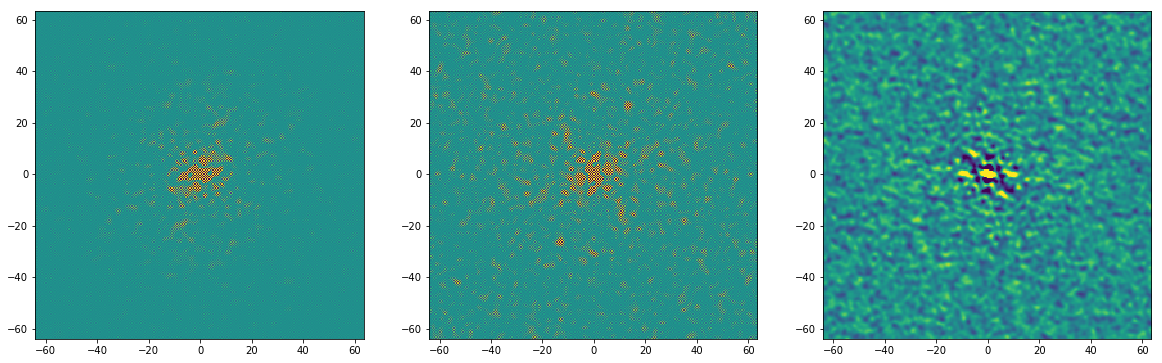

In [43]:
fig, ax = plt.subplots(1,3, figsize=(20,7))

umin = psf_pure.ugrid_raw0.min().value
umax = psf_pure.ugrid_raw0.max().value

ax[0].imshow(np.real(psf_pure.visibility[0,:,:].value),
             extent=(umin,umax,umin,umax), 
             origin='lower',vmin=-100., vmax = 100.)

ax[1].imshow(np.real(psf_poiss.visibility[0,:,:].value), 
             extent=(umin,umax,umin,umax), 
             origin='lower',vmin=-100., vmax = 100.)

# This takes quite a while because of the size of u0.
ax[2].imshow(np.real(psf_poiss_direct.visibility[0].reshape((N_u,N_u))), 
             extent=(umin,umax,umin,umax), 
             origin='lower',vmin=-100., vmax = 100.)

plt.show()

More usefully, we can determine circularly averaged quantities, such as the circularly averaged square visibility:

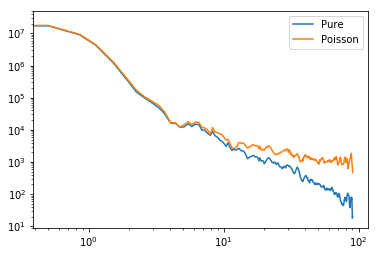

In [27]:
plt.plot(psf_pure.ugrid, psf_pure.visibility_squared_circular[0,0,:],    # Note the first two dimensions refer to frequency -- we just use nu0
         label="Pure") 
plt.plot(psf_poiss.ugrid, psf_poiss.visibility_squared_circular[0,0,:],
         label="Poisson")

plt.legend()
plt.xscale('log')
plt.yscale('log')

You can see the smallest scales have a significant shot-noise contribution.

### Covariance of Visibilities

Because it is such an important quantity, we also provide a function for generating the covariance of visibilities as a function of scale $u$. One can use it like this:

In [28]:
from spore.mock.utils import visibility_covariance

Basically, to the function we just pass a number of iterations, and then the arguments we would usually pass to the ``PointSourceForegrounds`` constructor. 
One thing to be careful of is *not* to set a seed in the spatial distribution -- otherwise each iteration will have the same realisation!

In [29]:
# Ensure seed is None
poisson_sky.seed = None

ubins, cov = visibility_covariance(
    niter= 50,  # Number of iterations from which to estimate covariance
    beam_model=gaussbeam,
    source_counts=pl_source_counts,
    spec_index_model = spec_index_dist,
    spatial_dist = poisson_sky
)

/home/steven/anaconda2/envs/spore/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in power


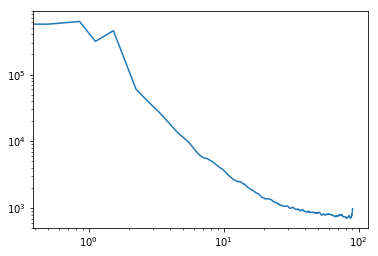

In [30]:
plt.plot(ubins, cov)
plt.xscale('log')
plt.yscale("log")